In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Import training dataset
df_train = pd.read_csv('train.csv')

In [3]:
# Define dictionary of output to description
Emotion = {0:'Anger',
           1:'Disgust',
           2:'Fear',
           3:'Happy',
           4:'Sad',
           5:'Surprise',
           6:'Neutral'}

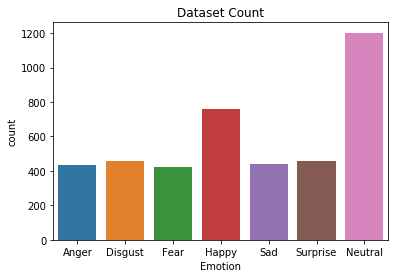

In [4]:
# Display dataset distribution
ax = sns.countplot(df_train['Emotion'])
ax.set(xticklabels = Emotion.values(), title = "Dataset Count")
plt.show()

In [5]:
# Define validation size set
val_size = 0.2

# Create a 3D array for our feature values
X = df_train['Pixels'].str.split(" ", expand = True)
X = np.asarray(X).astype(float)
X = X/255.0
X = X.reshape(-1,1,48,48)

# Create a 1D array for our target values
y = np.asarray(df_train['Emotion']).reshape(-1,1).astype(int)

# Stratify split the dataset to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y)

print(f'The number of items in X_train is {len(X_train)}.\nThe number of items in y_train is {len(y_train)}.\n')
print(f'The number of items in X_train is {len(X_val)}.\nThe number of items in y_train is {len(y_val)}.')

The number of items in X_train is 3342.
The number of items in y_train is 3342.

The number of items in X_train is 836.
The number of items in y_train is 836.


In [30]:
# Define function to display sample data
def display_tensor(x,y):
    plt.figure(figsize = (5,5))
    plt.imshow(x.reshape(48,48), cmap = 'gray')
    plt.title(y)
    plt.show()


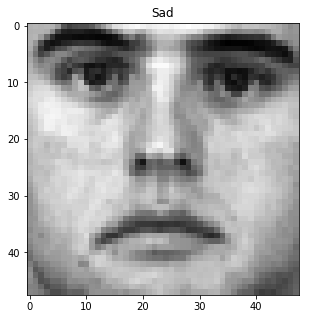

In [31]:
import random

display_samp(random.randint(0,len(X_train)))

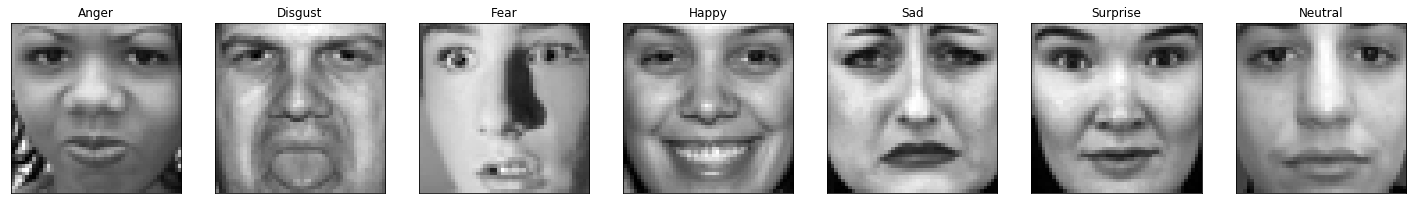

In [7]:
# Display sample faces per emotion
fig = plt.figure(figsize=(25, 4))
for i in range(len(Emotion)):
    ax = fig.add_subplot(1, 7, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[np.argmax(y_train == i)].reshape(48,48)), cmap='gray')
    ax.set_title(Emotion[int(y_train[np.argmax(y_train == i)])])

In [8]:
# Create PyTorch dataset from numpy

import torch.utils.data as utils
import torchvision.transforms as transforms

# Create tensors for train set
tensor_x = torch.stack([torch.Tensor(i) for i in X_train])
tensor_y = torch.stack([torch.Tensor(i) for i in y_train])

# Create train dataset
train_data = utils.TensorDataset(tensor_x, tensor_y)

# Create tensors for validation set
tensor_x = torch.stack([torch.Tensor(i) for i in X_val])
tensor_y = torch.stack([torch.Tensor(i) for i in y_val])

# Create validation dataset
valid_data = utils.TensorDataset(tensor_x, tensor_y)

In [9]:
# Define loading parameters and transforms
num_workers = 0
batch_size = 20

train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomHorizontalFlip()])
valid_transform = transforms.Compose([transforms.ToTensor()])

In [10]:
# Define data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           shuffle = True, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size,
                                           shuffle = True, num_workers = num_workers)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# https://arxiv.org/pdf/1302.4389v3.pdf  (student assistant solution)
# https://arxiv.org/ftp/arxiv/papers/1706/1706.01509.pdf (paper about emotion detection)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layer (sees 48x48x1 image tensor)
        self.conv1 = nn.Conv2d(1, 20, 5, padding = 3)
        # Convolutional layer (sees 24x24x10 image tensor)
        self.conv2 = nn.Conv2d(20, 20, 5, padding = 3)
        # Convolutional layer (sees 12x12x10 image tensor)
        self.conv3 = nn.Conv2d(20, 20, 3, padding = 1)
        
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(20*6*6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)
        
        self.dropout = nn.Dropout(p = 0.25)
        
        self.logsoftmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = x.view(-1, 6*6*20)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = Net()

In [12]:
# This line is added to upload the current best model parameters into the model based on previous training
# This line should not be used if the model was changed

# model.load_state_dict(torch.load('model.pth'))

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [14]:
from torch.autograd import Variable

n_epoch = 300

valid_loss_min = np.Inf
change_lr = 0
curr_lr = 0.01

for epoch in range(n_epoch):
    train_loss = 0
    valid_loss = 0

    
    model.train()
    model.to('cuda')
    
    if epoch == 100:
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
    if epoch == 200:
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)
    
    for data, target in train_loader:
        data, target = data.to('cuda'), target.to('cuda')
        target = target.squeeze()
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target.long()) 
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
    model.eval()
    
    for data, target in valid_loader:
        data, target = data.to('cuda'), target.to('cuda')
        target = target.squeeze()
        output = model.forward(data)
        loss = criterion(output, target.long())
        valid_loss += loss.item() * data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch {}\tTraining Loss: {:.6f}\tValidation Loss: {:.6f}'.format(
                epoch+1,
                train_loss,
                valid_loss,
                change_lr))
    
    if valid_loss < valid_loss_min:
        print('Validation loss improved ({:.6f} --> {:.6f})'.format(
                valid_loss_min,
                valid_loss))
        torch.save(model.state_dict(), 'model.pth')
        valid_loss_min = valid_loss


Epoch 1	Training Loss: 1.923422	Validation Loss: 1.896423
Validation loss improved (inf --> 1.896423)
Epoch 2	Training Loss: 1.880247	Validation Loss: 1.862526
Validation loss improved (1.896423 --> 1.862526)
Epoch 3	Training Loss: 1.857082	Validation Loss: 1.855018
Validation loss improved (1.862526 --> 1.855018)
Epoch 4	Training Loss: 1.855845	Validation Loss: 1.853813
Validation loss improved (1.855018 --> 1.853813)
Epoch 5	Training Loss: 1.853449	Validation Loss: 1.852220
Validation loss improved (1.853813 --> 1.852220)
Epoch 6	Training Loss: 1.851964	Validation Loss: 1.851883
Validation loss improved (1.852220 --> 1.851883)
Epoch 7	Training Loss: 1.850208	Validation Loss: 1.850548
Validation loss improved (1.851883 --> 1.850548)
Epoch 8	Training Loss: 1.847864	Validation Loss: 1.849402
Validation loss improved (1.850548 --> 1.849402)
Epoch 9	Training Loss: 1.847971	Validation Loss: 1.847249
Validation loss improved (1.849402 --> 1.847249)
Epoch 10	Training Loss: 1.849065	Validatio

Epoch 98	Training Loss: 0.386303	Validation Loss: 0.919281
Epoch 99	Training Loss: 0.371918	Validation Loss: 0.637496
Validation loss improved (0.637691 --> 0.637496)
Epoch 100	Training Loss: 0.348878	Validation Loss: 0.659656
Epoch 101	Training Loss: 0.313874	Validation Loss: 0.637847
Epoch 102	Training Loss: 0.297380	Validation Loss: 0.625918
Validation loss improved (0.637496 --> 0.625918)
Epoch 103	Training Loss: 0.285823	Validation Loss: 0.627558
Epoch 104	Training Loss: 0.275556	Validation Loss: 0.624803
Validation loss improved (0.625918 --> 0.624803)
Epoch 105	Training Loss: 0.299318	Validation Loss: 0.625599
Epoch 106	Training Loss: 0.300709	Validation Loss: 0.619476
Validation loss improved (0.624803 --> 0.619476)
Epoch 107	Training Loss: 0.283464	Validation Loss: 0.619109
Validation loss improved (0.619476 --> 0.619109)
Epoch 108	Training Loss: 0.288561	Validation Loss: 0.630961
Epoch 109	Training Loss: 0.282002	Validation Loss: 0.631241
Epoch 110	Training Loss: 0.292339	Val

Epoch 230	Training Loss: 0.201698	Validation Loss: 0.665666
Epoch 231	Training Loss: 0.220201	Validation Loss: 0.663929
Epoch 232	Training Loss: 0.198861	Validation Loss: 0.663411
Epoch 233	Training Loss: 0.216265	Validation Loss: 0.664450
Epoch 234	Training Loss: 0.204152	Validation Loss: 0.665508
Epoch 235	Training Loss: 0.211245	Validation Loss: 0.664844
Epoch 236	Training Loss: 0.217909	Validation Loss: 0.664857
Epoch 237	Training Loss: 0.202007	Validation Loss: 0.665757
Epoch 238	Training Loss: 0.202114	Validation Loss: 0.666011
Epoch 239	Training Loss: 0.204586	Validation Loss: 0.665738
Epoch 240	Training Loss: 0.210130	Validation Loss: 0.666002
Epoch 241	Training Loss: 0.210353	Validation Loss: 0.665253
Epoch 242	Training Loss: 0.227575	Validation Loss: 0.667324
Epoch 243	Training Loss: 0.212603	Validation Loss: 0.666790
Epoch 244	Training Loss: 0.200412	Validation Loss: 0.664266
Epoch 245	Training Loss: 0.210496	Validation Loss: 0.667623
Epoch 246	Training Loss: 0.213034	Valida

KeyboardInterrupt: 

In [15]:
def test_model(img, label, model):
    X = torch.Tensor(img.reshape(1,1,48,48))
    output = model(X)
    _, pred = torch.max(output,1)
    Emotion[int(pred)], label, pred
    display_tensor(X, f'Prediction: {Emotion[int(pred)]}\nActual:{label}')

In [16]:
# This line is added to upload the current best model parameters into the model based on previous training
model.load_state_dict(torch.load('model.pth'))

In [24]:
model.to('cpu')
from tqdm import tqdm

y_pred = []
corr = 0
for i in tqdm(range(len(X_val))):
    output = model(torch.Tensor(X_val[i].reshape(1,1,48,48)))
    _, pred = torch.max(output,1)
    if int(pred) == int(y_val[i]):
        corr += 1

print(corr/len(X_val))

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:01<00:00, 491.63it/s]


0.7464114832535885


In [ ]:
from sklearn.metrics import confusion_matrix

ax = sns.heatmap(confusion_matrix(y_pred, y_val), cmap='gray', annot = True)

In [26]:
corr = 0

for i in tqdm(range(len(X_val))):
    output = model(torch.Tensor(X_val[i].reshape(1,1,48,48)))
    _, pred = torch.max(output,1)
    if int(pred) == int(y_val[i]):
        corr += 1
print(corr/len(X_val))

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:01<00:00, 488.77it/s]


0.7392344497607656


In [ ]:
ran = wrong[6]

test_model(X[ran], Emotion[int(y[ran])], model)